In [291]:
# import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC                                 #1
from sklearn.neighbors import KNeighborsClassifier          #2
from sklearn.ensemble import RandomForestClassifier         #3
from sklearn.linear_model import LogisticRegression         #4
from sklearn.tree import DecisionTreeClassifier             #5
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score

In [292]:
# import datasets
obesity_data = pd.read_csv('file_path/Obesity DataSet.csv')
student_data = pd.read_csv('file_path/Student Dropout:Success.csv', sep=';')
bank_marketing_data = pd.read_csv('file_path//bank-full.csv', sep=';')
credit_clients_data = pd.read_excel('file_path/credit card clients.xls', header = 1)

In [293]:
# given the large size of bank_marketing_data anbd credit_clients_data, we will only use a random subset of instances

sample_size = student_data.shape[0]                 # using student_data as sample size reference
bank_marketing_data = bank_marketing_data.sample(n = sample_size, random_state=42)
credit_clients_data = credit_clients_data.sample(n = sample_size, random_state=42)

In [294]:
# converting multi-labels to binary labels

# convert the problem into binary classification: obese (1) or not obese (0)?
obesity_data["NObeyesdad"] = obesity_data["NObeyesdad"].map({"Obesity_Type_I": 1, "Obesity_Type_II": 1, "Obesity_Type_III": 1, "Overweight_Level_I": 0, "Overweight_Level_II": 0, "Normal_Weight": 0, "Insufficient_Weight": 0})

# binary classification task: dropout (1) or not dropout (0)?
student_data["Target"] = student_data["Target"].map({"Dropout": 1, "Graduate": 0, "Enrolled": 0})

# binary classification task: subscribed (1) or not subscribed (0)?
bank_marketing_data["y"] = bank_marketing_data["y"].map({"yes": 1, "no": 0})

# binary classification task for clients dataset: default (1) or not default (0)?

In [295]:
def pre_processing(df, target_column):
    
    # splitting features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # find categorical features
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    if len(categorical_features) != 0:
        # encode categorical features
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
        X_one_hot = encoder.fit_transform(X[categorical_features])
        one_hot_df = pd.DataFrame(X_one_hot, columns=encoder.get_feature_names_out(categorical_features))

        # drop original categorical features and concatenate one hot encoded features to original dataframe
        X = pd.concat([X.drop(categorical_features, axis=1, inplace=True), one_hot_df], axis=1)
    
    return X, y

In [296]:
# pre-processing all four datasets

obesity_features, obesity_target = pre_processing(obesity_data, "NObeyesdad")
student_features, student_target = pre_processing(student_data, "Target")
bank_marketing_features, bank_marketing_target = pre_processing(bank_marketing_data, "y")
credit_clients_features, credit_clients_target = pre_processing(credit_clients_data, "default payment next month")

In [297]:
# Initialize Classifiers
svm = SVC()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression()
dt = DecisionTreeClassifier()

classifiers = {"SVM": svm, "KNN": knn, "RF": rf, "LR": lr, "DT": dt}

In [298]:
def train_and_evaluate(X, y, test_size, classifiers, random_state=42, trials = 3):
    
    scaler = StandardScaler()
    results = {name: {0.2: {"train": [], "val": [], "test": []},
                      0.5: {"train": [], "val": [], "test": []},
                      0.8: {"train": [], "val": [], "test": []}} for name in classifiers}
  
    for name, clf in classifiers.items():
        for test_size in [0.2, 0.5, 0.8]:
            for trial in range(trials):
                print(f"Training {name} \n Dataset: {y.name} \n Test Size: {test_size} \n Trial: {trial+1} \n")

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state + trial)

                if name in ["SVM", "KNN", "LR"]:                # apply scaling only for SVM, KNN and LR
                    X_train = scaler.fit_transform(X_train)
                    X_test = scaler.transform(X_test)   

                parameter_grid = {
                "SVM": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
                "KNN": {"n_neighbors": [3, 5, 7]},
                "RF": {"n_estimators": [100, 200, 500], "max_depth": [None, 10, 20]},
                "LR": {"C": [0.1, 1, 10]},
                "DT": {"max_depth": [None, 5, 10], "min_samples_split": [2, 5, 10]},
                }

                grid = GridSearchCV(clf, parameter_grid[name], scoring="accuracy")
                grid.fit(X_train, y_train)
                
                best_model = CalibratedClassifierCV(grid.best_estimator_, method='sigmoid')             #Platt Scaling
                best_model.fit(X_train, y_train)

                val_accuracy  = grid.best_score_
                train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
                test_accuracy = accuracy_score(y_test, best_model.predict(X_test))


                results[name][test_size]["val"].append(val_accuracy)
                results[name][test_size]["train"].append(train_accuracy)
                results[name][test_size]["test"].append(test_accuracy)
                print (f"Val Accuracy: {val_accuracy} \n Train Accuracy: {train_accuracy} \n Test Accuracy: {test_accuracy} \n")
                
    average_results = {
        name: {
            test_size:{
                "train": sum(scores["train"]) / 3,
                "val": sum(scores["val"]) / 3,
                "test": sum(scores["test"]) / 3
            }
            for test_size, scores in results[name].items()
        }
        for name, results[name] in results.items()
    }

    return average_results

In [287]:
student_results = train_and_evaluate(student_features, student_target, test_size, classifiers, trials=3)

Training SVM 
 Dataset: Target 
 Test Size: 0.2 
 Trial: 1 

Val Accuracy: 0.8711504806655 
 Train Accuracy: 0.8728454365640012 
 Test Accuracy: 0.8564971751412429 

Training SVM 
 Dataset: Target 
 Test Size: 0.2 
 Trial: 2 

Val Accuracy: 0.8688917923269324 
 Train Accuracy: 0.8722803051709522 
 Test Accuracy: 0.8655367231638418 

Training SVM 
 Dataset: Target 
 Test Size: 0.2 
 Trial: 3 

Val Accuracy: 0.8654975667058231 
 Train Accuracy: 0.8968635207685787 
 Test Accuracy: 0.8666666666666667 

Training SVM 
 Dataset: Target 
 Test Size: 0.5 
 Trial: 1 

Val Accuracy: 0.8752213926028825 
 Train Accuracy: 0.8806509945750453 
 Test Accuracy: 0.8607594936708861 

Training SVM 
 Dataset: Target 
 Test Size: 0.5 
 Trial: 2 

Val Accuracy: 0.8661889829729426 
 Train Accuracy: 0.8716094032549728 
 Test Accuracy: 0.8711573236889693 

Training SVM 
 Dataset: Target 
 Test Size: 0.5 
 Trial: 3 

Val Accuracy: 0.8752316067944802 
 Train Accuracy: 0.8788426763110307 
 Test Accuracy: 0.85714285

In [300]:
credit_clients_results = train_and_evaluate(credit_clients_features, credit_clients_target, test_size, classifiers, trials=3)

Training SVM 
 Dataset: default payment next month 
 Test Size: 0.2 
 Trial: 1 

Val Accuracy: 0.8191594946419581 
 Train Accuracy: 0.8279174908166148 
 Test Accuracy: 0.8011299435028248 

Training SVM 
 Dataset: default payment next month 
 Test Size: 0.2 
 Trial: 2 

Val Accuracy: 0.8157632712423786 
 Train Accuracy: 0.8282000565131393 
 Test Accuracy: 0.8124293785310734 

Training SVM 
 Dataset: default payment next month 
 Test Size: 0.2 
 Trial: 3 

Val Accuracy: 0.8177434692621803 
 Train Accuracy: 0.8293303192992371 
 Test Accuracy: 0.8 

Training SVM 
 Dataset: default payment next month 
 Test Size: 0.5 
 Trial: 1 

Val Accuracy: 0.8160015525571229 
 Train Accuracy: 0.8277576853526221 
 Test Accuracy: 0.7992766726943942 

Training SVM 
 Dataset: default payment next month 
 Test Size: 0.5 
 Trial: 2 

Val Accuracy: 0.8056106554446748 
 Train Accuracy: 0.8273056057866185 
 Test Accuracy: 0.8119349005424955 

Training SVM 
 Dataset: default payment next month 
 Test Size: 0.5 
 

In [303]:
bank_marketing_results = train_and_evaluate(bank_marketing_features, bank_marketing_target, test_size, classifiers, trials=3)

Training SVM 
 Dataset: y 
 Test Size: 0.2 
 Trial: 1 

Val Accuracy: 0.8790624825194385 
 Train Accuracy: 0.8813224074597343 
 Test Accuracy: 0.911864406779661 

Training SVM 
 Dataset: y 
 Test Size: 0.2 
 Trial: 2 

Val Accuracy: 0.8892363691574969 
 Train Accuracy: 0.8897993783554676 
 Test Accuracy: 0.8779661016949153 

Training SVM 
 Dataset: y 
 Test Size: 0.2 
 Trial: 3 

Val Accuracy: 0.8883861146405196 
 Train Accuracy: 0.8892342469624188 
 Test Accuracy: 0.880225988700565 

Training SVM 
 Dataset: y 
 Test Size: 0.5 
 Trial: 1 

Val Accuracy: 0.8820066800813049 
 Train Accuracy: 0.8838155515370705 
 Test Accuracy: 0.8910488245931284 

Training SVM 
 Dataset: y 
 Test Size: 0.5 
 Trial: 2 

Val Accuracy: 0.889696944935293 
 Train Accuracy: 0.8896925858951176 
 Test Accuracy: 0.8851717902350814 

Training SVM 
 Dataset: y 
 Test Size: 0.5 
 Trial: 3 

Val Accuracy: 0.8883384574527848 
 Train Accuracy: 0.8901446654611211 
 Test Accuracy: 0.8847197106690777 

Training SVM 
 Data

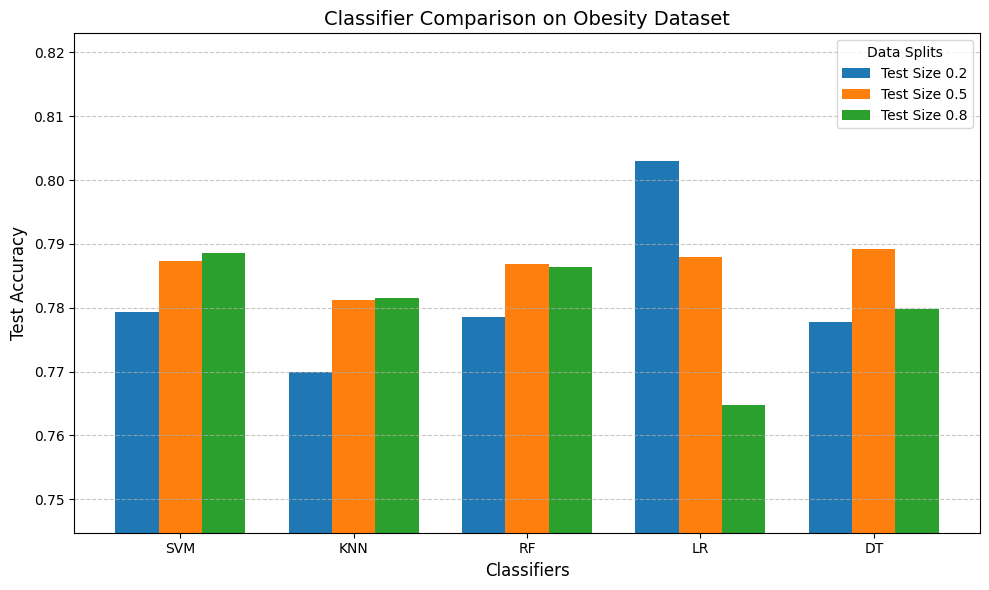

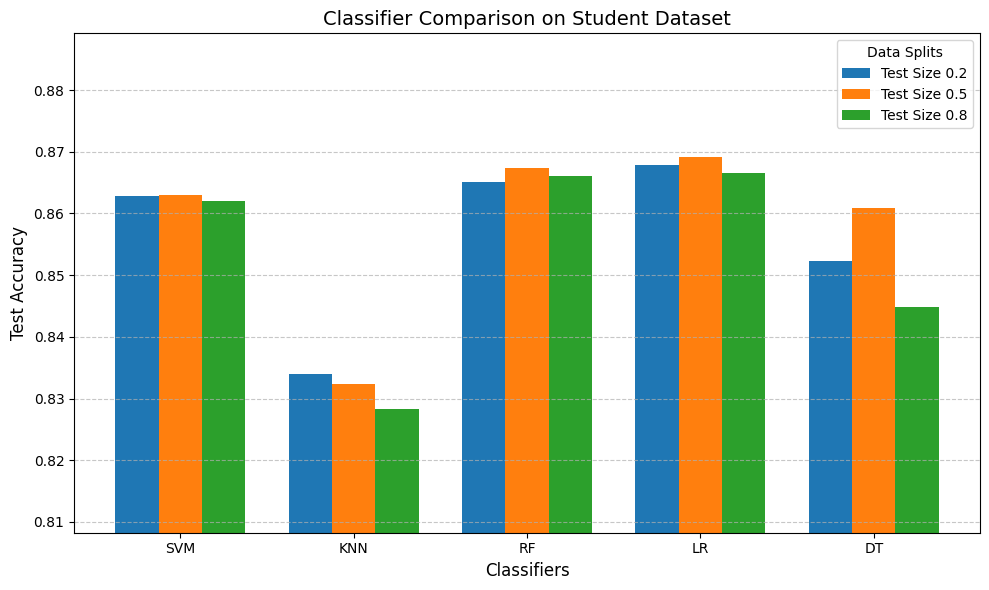

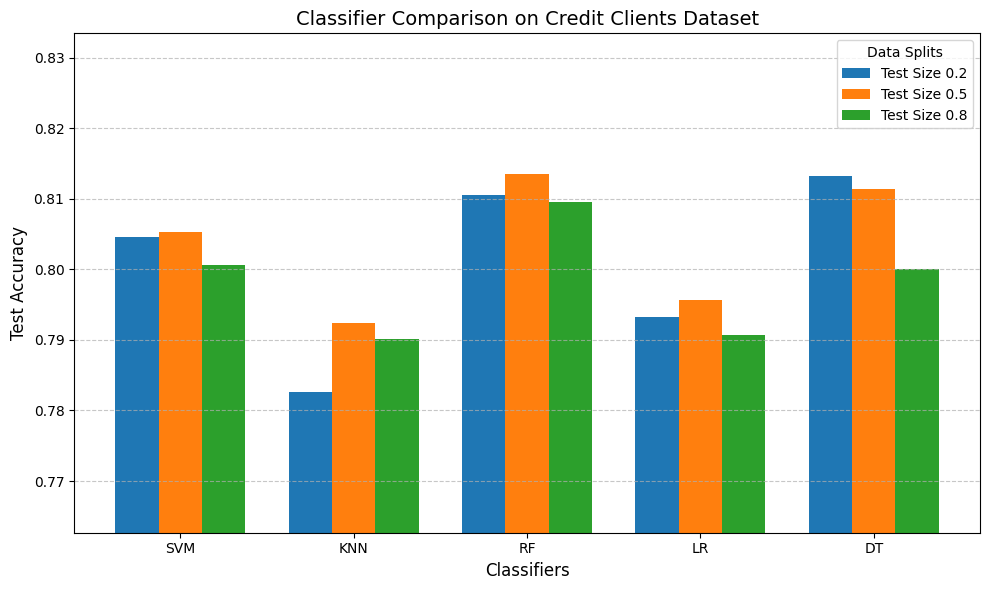

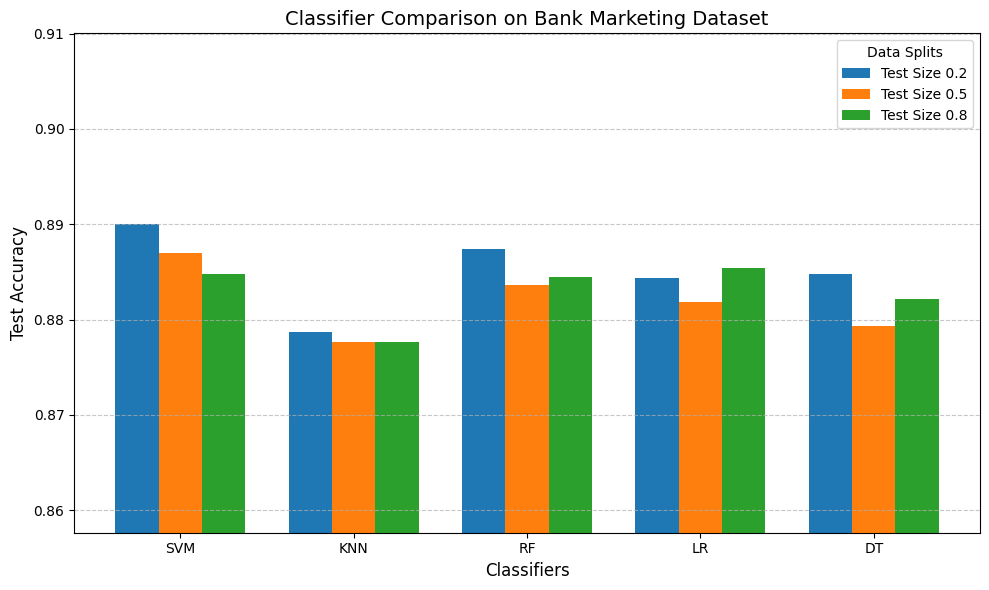

In [310]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to extract and prepare data for plotting
def prepare_data_for_plotting(results, dataset_name):
    classifiers = list(results.keys())
    test_sizes = [0.2, 0.5, 0.8]
    
    # Extract testing accuracies
    data = {size: [results[clf][size]["test"] for clf in classifiers] for size in test_sizes}
    
    return classifiers, test_sizes, data

# Function to plot grouped bar chart
def plot_grouped_bar_chart(classifiers, test_sizes, data, title):
    x = np.arange(len(classifiers))  # X-axis positions for classifiers
    bar_width = 0.25  # Width of each bar

    all_test_accuracies = [value for size_data in data.values() for value in size_data]
    y_min = min(all_test_accuracies) - 0.02  # Slightly below the minimum value
    y_max = max(all_test_accuracies) + 0.02  # Slightly above the maximum value

    # Initialize plot
    plt.figure(figsize=(10, 6))
    
    # Plot bars for each test size
    for i, size in enumerate(test_sizes):
        plt.bar(x + i * bar_width, data[size], bar_width, label=f"Test Size {size}")
    
    plt.ylim(y_min, y_max)  # Adjust Y-axis to focus on the range of test accuracies

    # Add labels, title, and legend
    plt.xlabel("Classifiers", fontsize=12)
    plt.ylabel("Test Accuracy", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(x + bar_width, classifiers)  # Set x-tick positions and labels
    plt.legend(title="Data Splits", fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot results for each dataset
datasets = [("Obesity Dataset", obesity_results), 
            ("Student Dataset", student_results),
            ("Credit Clients Dataset", credit_clients_results),
            ("Bank Marketing Dataset", bank_marketing_results)]

for dataset_name, results in datasets:
    classifiers, test_sizes, data = prepare_data_for_plotting(results, dataset_name)
    plot_grouped_bar_chart(classifiers, test_sizes, data, f"Classifier Comparison on {dataset_name}")


In [314]:

# Create a function to generate the table
def create_results_table(datasets_results, dataset_names, test_sizes):
    classifiers = list(datasets_results[0].keys())  # Extract classifier names from results
    table_data = []  # To hold rows of the table
    
    for classifier in classifiers:
        row = {"Classifier": classifier}
        total_sum = 0  # To calculate the mean accuracy across datasets and test sizes
        total_count = 0

        for dataset_name, results in zip(dataset_names, datasets_results):
            for test_size in test_sizes:
                # Fetch test accuracy for the current classifier, dataset, and test size
                accuracy = results[classifier][test_size]["test"]
                accuracy = round(accuracy, 3)
                row[f"{dataset_name} (Test Size {test_size})"] = accuracy
                
                # Add to total for mean calculation
                total_sum += accuracy
                total_count += 1
        
        # Add mean accuracy column
        row["Mean Accuracy"] = round(total_sum / total_count, 3)
        table_data.append(row)
    
    # Convert table data into a DataFrame
    columns = ["Classifier"] + [
        f"{dataset} (Test Size {size})" for dataset in dataset_names for size in test_sizes
    ] + ["Mean Accuracy"]
    table_df = pd.DataFrame(table_data, columns=columns)
    
    # Sort by Mean Accuracy
    table_df = table_df.sort_values(by="Mean Accuracy", ascending=False).reset_index(drop=True)
    return table_df

# Dataset results (example)
datasets_results = [
    obesity_results,
    student_results,
    credit_clients_results,
    bank_marketing_results,
]

# Dataset names
dataset_names = ["Obesity", "Student", "Credit Clients", "Bank Marketing"]

# Test sizes
test_sizes = [0.2, 0.5, 0.8]

# Generate the table
results_table = create_results_table(datasets_results, dataset_names, test_sizes)

# Display the table
results_table.head()

,Classifier,Obesity (Test Size 0.2),Obesity (Test Size 0.5),Obesity (Test Size 0.8),Student (Test Size 0.2),Student (Test Size 0.5),Student (Test Size 0.8),Credit Clients (Test Size 0.2),Credit Clients (Test Size 0.5),Credit Clients (Test Size 0.8),Bank Marketing (Test Size 0.2),Bank Marketing (Test Size 0.5),Bank Marketing (Test Size 0.8),Mean Accuracy
0,RF,0.779,0.787,0.786,0.865,0.867,0.866,0.811,0.813,0.810,0.887,0.884,0.884,0.837
1,SVM,0.779,0.787,0.789,0.863,0.863,0.862,0.805,0.805,0.801,0.890,0.887,0.885,0.835
2,LR,0.803,0.788,0.765,0.868,0.869,0.866,0.793,0.796,0.791,0.884,0.882,0.885,0.833
3,DT,0.778,0.789,0.780,0.852,0.861,0.845,0.813,0.811,0.800,0.885,0.879,0.882,0.831
4,KNN,0.770,0.781,0.782,0.834,0.832,0.828,0.783,0.792,0.790,0.879,0.878,0.878,0.819
